In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 11 Lab - Model Evaluation

## Directions

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

In [4]:
import models

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We'll be working with the insurance data.

**1. Load the data, perform your transformations, and using the Bootstrap version of the Linear Regression function, estimate your final model from Lab 10 and show the Bootstrap results**

Referring to answer from Lab10 solution, final model can be generated as below

In [5]:
insurance = pd.read_csv( "insurance.csv", header=0)

In [6]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)

In [7]:
insurance["age_sq"] = insurance.age**2
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

Bootstrap Results:

In [8]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

'Model: charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children\n----------------------  ---------  --------  --------  --------\n                                             95% BCI\nCoefficients                       Mean      Lo        Hi\n                        $\\beta_0$  2596.82   611.48    3215.23\nage_sq                  $\\beta_1$  3.33      3.13      3.57\nmale                    $\\beta_2$  -535.53   -980.52   97.87\nbmi                     $\\beta_3$  -14.33    -32.39    43.13\nsmoke_yes               $\\beta_4$  2981.16   -2051.62  5856.43\nsmoke_yes:bmi           $\\beta_5$  414.89    312.57    597.72\nsmoke_yes:bmi_above_30  $\\beta_6$  15607.52  13530.68  16899.12\nchildren                $\\beta_7$  742.99    435.59    961.89\nmale:children           $\\beta_8$  -208.48   -414.62   217.96\n\nMetrics                 Mean       Lo        Hi\n$\\sigma$                4440.12    3941.03   4705.71\n$R^2$                

**2. Perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Using the results for the test data, calculate 95% Bootstrap estimates of the credible intervals for each.** Comment on these intervals and the intervals from above. Are the average values different? Are the intervals different?

In [9]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

def sse(results):
    errors = results['residuals']
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

def r2(results):
    r2 = results['r_squared']
    return r2

def sigma(results):
    s = results['sigma']
    return s

def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

#### R Squared

In [10]:
result_r2 = cross_validation(models.linear_regression, model, insurance, r2)

In [11]:
print("R squared estimate: ",np.mean(result_r2))

R squared estimate:  0.8635749567305052


In [12]:
posterior_r2 = np.array([np.mean(s) for s in [resample(result_r2) for i in range( 0,1000)]])


In [13]:
print("95% CI for mean R^2:", stats.mstats.mquantiles(posterior_r2, [0.025, 0.975]))

95% CI for mean R^2: [0.84988503 0.87943462]


The 95% CI bound for R^2 is narrow

#### Sigma

In [14]:
result_sigma = cross_validation(models.linear_regression, model, insurance, sigma)

In [15]:
print("Sigma estimate: ", np.mean(result_sigma))

Sigma estimate:  4479.970759537451


In [16]:
posterior_sigma = np.array([np.mean(s) for s in [resample(result_sigma) for i in range( 0,1000)]])

In [17]:
print("95% CI for mean sigma:", stats.mstats.mquantiles(posterior_sigma, [0.025, 0.975]))

95% CI for mean sigma: [4229.24302453 4679.33889765]


The 95% CI bound for sigma is narrow

**3. Using Learning Curves and $\sigma$ determine if more data will improve the estimation of the model.**

In [18]:
from collections import defaultdict
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

In [19]:
results = learning_curves(models.linear_regression, model, insurance, sigma)

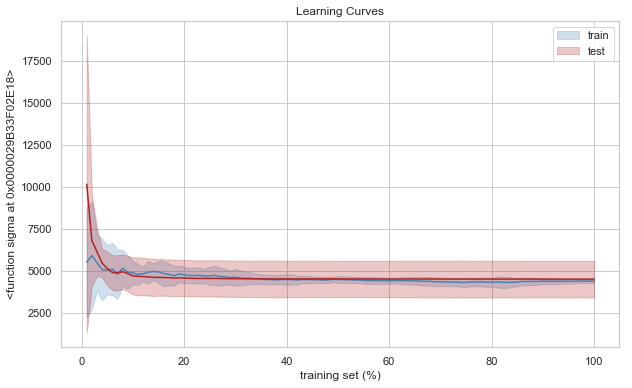

In [20]:
plot_learning_curves(results, sigma)

Since two curves are well converged which means the model is in a high bias state, more data would unlikely help in improving the model

**4. It was shown that `age_sq` improved the performance of the model. Perhaps a different polynomial would have been better. Generate Validation Curves for `age` = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5] and select the best transformation.**

In [21]:
 def validation_curves(algorithm, formulas, data, values, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i, p in enumerate(zip(formulas, values)):
                f, v = p
                # it's ok to resuse the folds for each v of values
                # we calculate the model
                result = algorithm(f, train_data, v)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices(f, train_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices(f, test_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results


def plot_validation_curves( results, metric, parameter, values, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( values, train_mean, color="steelblue")
    axes.fill_between( values, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( values, test_mean, color="firebrick")
    axes.fill_between( values, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( parameter)
    axes.set_ylabel( metric)
    axes.set_title("Validation Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()


In [22]:
values = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
formulas = []
for v in values:
    insurance["age_" + str(v).replace('.', '_')] = insurance["age"] ** v
    

for v in values:
    f = model + " + age_" + str(v).replace('.', '_')
    formulas.append(f)

def f(formula, data, v):
    return models.linear_regression(formula, data, style="linear")

result = validation_curves(f, formulas, insurance, values, sigma)

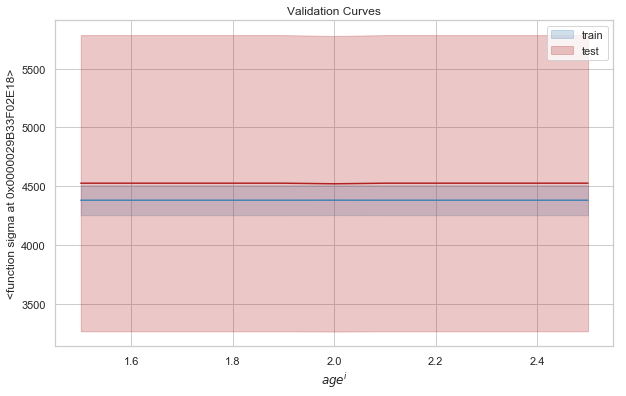

In [23]:
plot_validation_curves(result, sigma, r"$age^i$", values)

**5. Using Ridge Regression to estimate a model for the insurance data. Compare it with your final Linear Regression model.** (If you get far ahead, you may need to write your own function. Here are the sklearn docs: http://scikit-learn.org/stable/modules/linear_model.html)

In [24]:
df = insurance[['charges','age_sq','male','bmi','smoke_yes','bmi_above_30', 'children']]

In [25]:
from sklearn.linear_model import Ridge

y = df["charges"]
X = df.drop('charges', axis = 1 )
clf = Ridge(alpha=1.0)
clf.fit(X, y) 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [26]:
clf.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [27]:
clf.score(X,y)

0.7575554816493211

Based on the R^2, Ridge Regressoin is not better than our final linear regression model